# IMDB-BINARY graph classification: geometric scattering + SVM

Dave Johnson

An implementation of: <br>
Feng Gao, Guy Wolf, Matthew Hirn (2019). Geometric Scattering for Graph Data Analysis. <br>
Proceedings of the 36th International Conference on Machine Learning, PMLR 97:2122-2131. <br>
arXiv:1810.03068 

In [11]:
from importlib import reload
import data_proc_fns as df
import numpy as np

## Graph data import

In [169]:
graphs_l, labels = df.import_IMDBB_graphs(return_df=False)

### Dataset stats

IMDB-Binary descriptive stats:

num. graphs = 1000

num. nodes:
-----------
min     12
max     136
median  17.0


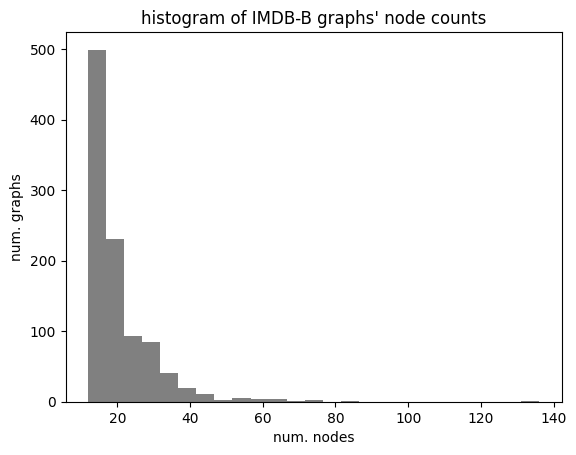

In [170]:
df.get_IMDBB_graphs_stats(graphs_l, labels)

### Inspect a graph

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 3), (1, 4), (1, 7), (1, 10), (1, 11), (2, 5), (2, 6), (2, 8), (2, 9), (2, 11), (2, 12), (2, 13), (3, 4), (3, 7), (3, 10), (3, 11), (4, 7), (4, 10), (4, 11), (5, 6), (5, 8), (5, 9), (5, 11), (5, 12), (5, 13), (6, 8), (6, 9), (6, 11), (6, 12), (6, 13), (7, 10), (7, 11), (8, 9), (8, 11), (8, 12), (8, 13), (9, 11), (9, 12), (9, 13), (10, 11), (11, 12), (11, 13), (12, 13)]


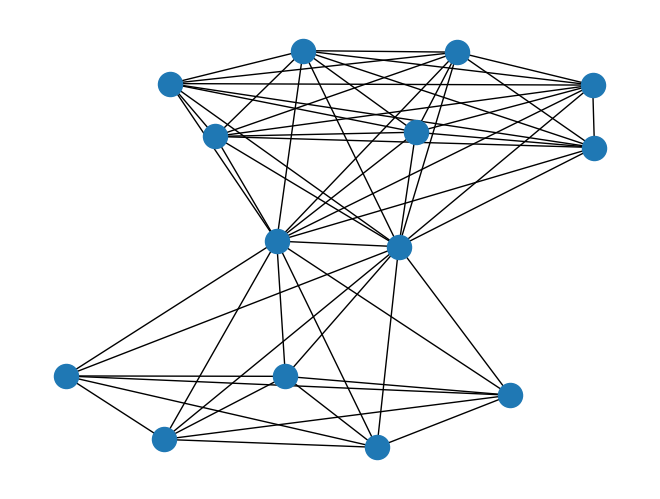

In [171]:
import matplotlib.pyplot as plt
import networkx as nx
test_graph = graphs_l[4]

print(test_graph.edges)
nx.draw(test_graph)
plt.show()

## Model

### SVM classifier

https://scikit-learn.org/stable/modules/svm.html

"For optimal performance, use C-ordered numpy.ndarray (dense) or scipy.sparse.csr_matrix (sparse) with dtype=float64."

In [167]:
import time
import scatter_fns as sf
reload(sf)

start = time.time()
smfm = sf.get_graphs_feat_matrix(graphs_l=graphs_l, 
                                 Q=4,
                                 feat_type='dirac', #'default',
                                 standardize_feats=True,
                                 indexes=[1, 3, 5, 7, 9, 11])
elapsed = time.time() - start
print(f'{elapsed:.4f} sec')

# 26.8006 sec for feat_type='dirac', indexes=[1, 3, 5, 7, 9, 11]
# 9.5089 sec for feat_type='default'

26.5911 sec


### Inspect NaN values

Generated by sklearn's `skew` and `kurtosis` with `feat_type='default'` in `get_graphs_feat_matrix()` above.

In [150]:
np.argwhere(np.isnan(smfm))

array([], shape=(0, 2), dtype=int64)

In [149]:
graph_idx = 997 # 6
nan_idxs = np.argwhere(np.isnan(smfm[graph_idx, :])).flatten().tolist()
[keys_l[i] for i in nan_idxs]

[]

### Optional: Replace NaNs with 0s

In [153]:
np.nan_to_num(smfm, nan=0.0, copy=False)
print(smfm.shape)
print(smfm)

(1000, 384)
[[0.56129032 0.58186592 0.13082881 ... 0.02689464 0.04244931 0.04114767]
 [0.31451613 0.33253087 0.27859939 ... 0.18992317 0.13288585 0.00469328]
 [0.52995392 0.55076843 0.144805   ... 0.0221514  0.02481127 0.02669075]
 ...
 [0.34193548 0.36073733 0.25644693 ... 0.85286682 1.         1.        ]
 [0.31451613 0.33253087 0.27859939 ... 0.10459354 0.11187777 0.12053793]
 [0.40942928 0.42963334 0.20954857 ... 0.0453073  0.05404865 0.060632  ]]


## Fit SVMs with CV

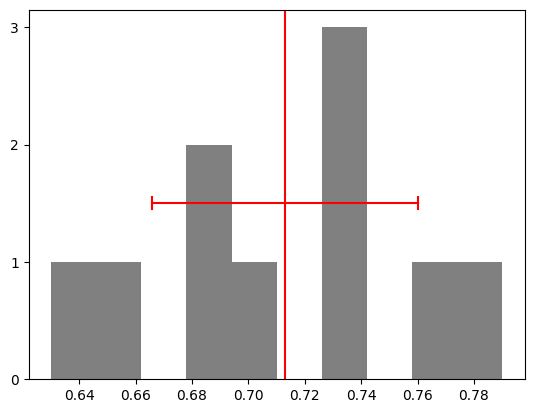

10-fold CV accuracy (%):
------------------------
mean     71.3
st dev   4.7
range    63.0 - 79.0

fold(k)  accuracy(%)
--------------------
1        66.0
2        77.0
3        63.0
4        74.0
5        73.0
6        74.0
7        68.0
8        70.0
9        69.0
10       79.0


In [168]:
import model_fns as mf
# reload(mf)

fold_accs = mf.fit_svm(
    graphs_l, 
    labels,
    smfm,
    C=2000.0,
    kernel='rbf', 
    degree=3,
    n_splits=10,
    random_state=948724
)
mf.print_cv_res(fold_accs)

## Diagnostics

### Feature matrix generation

In [ ]:
import scatter_fns as sf
import utility_fns as uf
reload(sf)
reload(uf)

ex_graph = graphs_l[0]

# raw_feat_matrix = sf.get_raw_feat_matrix(ex_graph)
# feat_names = ('eccent', 'clustc')

indexes=[1, 3, 5, 7, 9, 11]
raw_feat_matrix = sf.get_raw_feat_matrix(ex_graph,
                                        feat_type='dirac',
                                        indexes=indexes)
feat_names = [str(idx) for idx in indexes]
print(raw_feat_matrix)

Psi_l = sf.get_Psis(ex_graph, J=5)
feat_d, feat_v = sf.get_scat_mom_feat_v(raw_feat_matrix, 
                                        Psi_l, 
                                        Q=4, 
                                        normalize=True,
                                        feat_names=feat_names)
print(f'len = {len(feat_v)}')
print(feat_v)
# print(feat_d)

# flat_d = uf.flatten_dict(feat_d)
# flat_d

# keys_l = uf.flatten_dict_keys(feat_d)
# print(len(keys_l))
# keys_l

### Check k-folds splits

In [4]:
for i, (train_index, test_index) in enumerate(splits):
    print(f"Fold {i}:")
    print(f"  train: index={train_index[:10]} (n={len(train_index)})")
    print(f"  tbest:  index={test_index[:10]} (n={len(test_index)})")

Fold 0:
  train: index=[ 0  2  3  4  5  6  7  8 11 12] (n=900)
  tbest:  index=[ 1  9 10 13 17 30 36 38 49 71] (n=100)
Fold 1:
  train: index=[ 1  2  3  6  7  8  9 10 11 12] (n=900)
  tbest:  index=[ 0  4  5 14 16 28 39 44 45 62] (n=100)
Fold 2:
  train: index=[0 1 2 3 4 5 6 7 8 9] (n=900)
  tbest:  index=[ 12  37  51  67  68  76  78  91  92 101] (n=100)
Fold 3:
  train: index=[ 0  1  2  3  4  5  6  8  9 10] (n=900)
  tbest:  index=[  7  27  58  65  66  90  95 100 104 107] (n=100)
Fold 4:
  train: index=[ 0  1  2  4  5  7  8  9 10 11] (n=900)
  tbest:  index=[ 3  6 21 22 33 35 40 50 56 57] (n=100)
Fold 5:
  train: index=[ 0  1  3  4  5  6  7  8  9 10] (n=900)
  tbest:  index=[ 2 18 19 20 29 41 42 54 60 69] (n=100)
Fold 6:
  train: index=[ 0  1  2  3  4  5  6  7  9 10] (n=900)
  tbest:  index=[  8  24  34  43  48  59  79 109 130 137] (n=100)
Fold 7:
  train: index=[0 1 2 3 4 5 6 7 8 9] (n=900)
  tbest:  index=[ 11  15  31  32  46  55  75  82 108 120] (n=100)
Fold 8:
  train: index=[0 1 

### Misc

In [ ]:
import scatter_fns as sf
Psi_l = sf.get_Psis(graphs_l[4], 5)
raw_feat_matrix = sf.get_raw_feat_matrix(graphs_l[4])
smfd = sf.get_scat_mom_feat_v(raw_feat_matrix,
                           Psi_l,
                           4,
                           True,
                           True)
smfd

In [ ]:
import scatter_fns as sf
import numpy as np

x1 = np.array([1, 2, 3])
x2 = np.array([-1, -4, 7])
raw_feat_matrix = np.column_stack((x1, x2))
# raw_feat_matrix

In [12]:
sf.get_scat_mom(raw_feat_matrix, Q=4, normalize=False)

{0: {'0th': [6, 14, 36, 98], '1st': [], '2nd': []},
 1: {'0th': [2, 66, 278, 2658], '1st': [], '2nd': []}}

In [7]:
# (inefficient) check
for f in range(raw_feat_matrix.shape[1]):
    v = raw_feat_matrix[:, f]
    out = [np.sum(np.power(v, q)) for q in range(1, 5)]
    print(out)
    

[6, 14, 36, 98]
[2, 66, 278, 2658]


In [14]:
np.concatenate((x1, x2))

array([ 1,  2,  3, -1, -4,  7])

In [16]:
norm_fns = {
    0: np.mean,
    1: np.var
}

norm_fns[0](x1)

2.0

In [21]:
x = np.vstack([x1, x2])
(x - x.min(axis=0)) / \
    x.ptp(axis=0)

array([[1., 1., 0.],
       [0., 0., 1.]])